<a href="https://colab.research.google.com/github/Monishgalla/Classifying-different-land-uses-in-satellite-images-using-CNN/blob/main/Finalcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the essential libraries

In [1]:
!pip install rasterio[s3]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.3 MB/s eta 0:00:00


In [2]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For visualization of plots without plt.show()
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define the required variable

In [4]:
dataset_url = r'/content/drive/MyDrive/dataset/UCMerced_LandUse/Images'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

# Data preparation for the model

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 2118 files belonging to 21 classes.


In [6]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 1695 images belonging to 21 classes.


In [7]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 423 images belonging to 21 classes.


# Visualization of input datasets

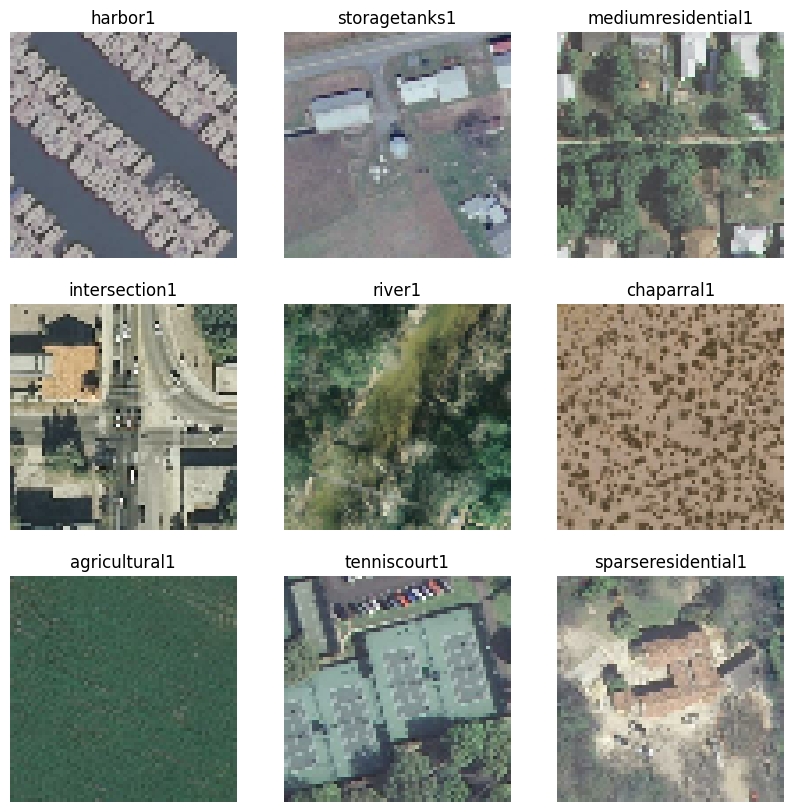

In [8]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# ResNet50 Model building

In [9]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [10]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)


    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [11]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)


    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

# Model train

In [21]:
model = ResNet50(input_shape=(64,64,3), classes=21)

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# please increase the epoch for higher accuracy (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, batch_size=32)

Epoch 1/20
53/53 [==============================] - 499s 9s/step - loss: 3.9210 - accuracy: 0.1711 - val_loss: 2.9745 - val_accuracy: 0.1466
Epoch 2/20
53/53 [==============================] - 295s 6s/step - loss: 2.6078 - accuracy: 0.2543 - val_loss: 2.5239 - val_accuracy: 0.2057
Epoch 3/20
53/53 [==============================] - 300s 6s/step - loss: 2.3148 - accuracy: 0.3434 - val_loss: 2.3531 - val_accuracy: 0.2459
Epoch 4/20
53/53 [==============================] - 304s 6s/step - loss: 2.4007 - accuracy: 0.3699 - val_loss: 3.9466 - val_accuracy: 0.2199
Epoch 5/20
53/53 [==============================] - 300s 6s/step - loss: 1.9499 - accuracy: 0.4360 - val_loss: 2.6464 - val_accuracy: 0.2931
Epoch 6/20
53/53 [==============================] - 289s 5s/step - loss: 1.7240 - accuracy: 0.4814 - val_loss: 2.8614 - val_accuracy: 0.2506
Epoch 7/20
53/53 [==============================] - 289s 5s/step - loss: 1.6091 - accuracy: 0.5298 - val_loss: 2.3657 - val_accuracy: 0.3168
Epoch 8/20
53

In [24]:
model.save('lulc_20_epoch')

# analyzing results and visualization

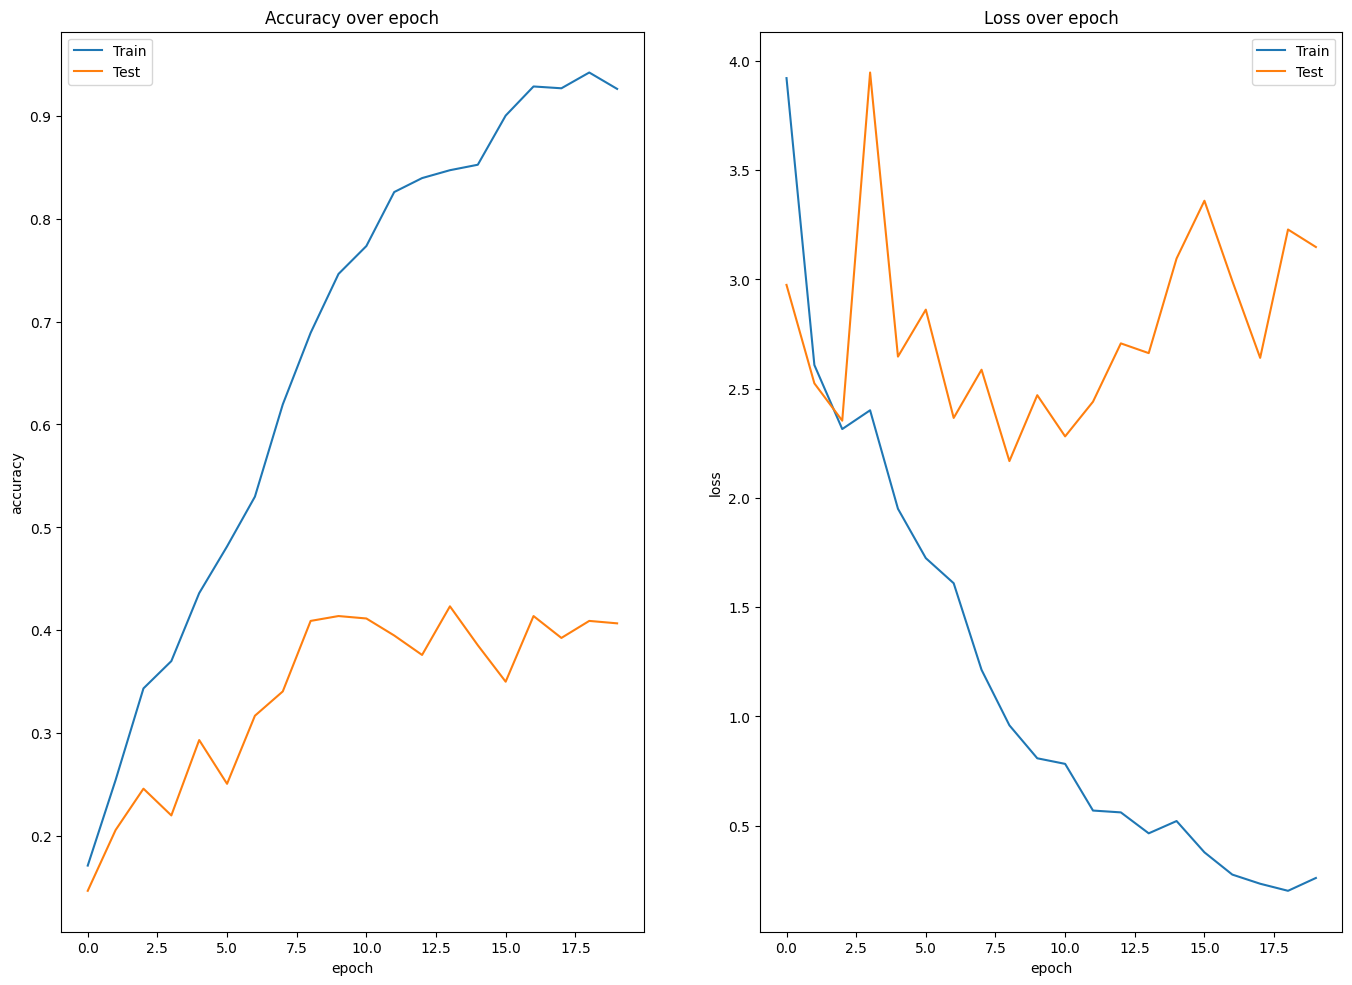

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

# Confusion matrix

In [26]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 452ms/step


In [27]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[294,   0,   0,  21,   0,   0,   0,  49,  24,   1,   0,   0,   0,
          0,   0,  39,   0,   0,   0,   0,   2],
       [  0, 249,   0,  28,  22,   0,   0,   0,   0,   0,   0,   0,   0,
         11,   4,   5,   0,  13,  38,  50,  11],
       [  0,   0, 254,   1,   0,   0,   0,   0,   3, 142,   0,   0,   0,
          0,   0,   0,  14,   0,  12,   2,   5],
       [  0,   1,   0, 419,   1,   0,   0,   0,   1,   0,   3,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   5],
       [  0,   0,   0,   0, 158,   0,  40,   0,   0,   0,   0,   2, 127,
         47,   2,  23,   1,   3,   3,  17,   8],
       [113,   1,   0,   0,   0, 273,   1,   0,   2,   8,   0,   0,   0,
          0,   0,   0,   0,  32,   0,   0,   0],
       [  0,   0,   0,   0,  17,   0, 114,   0,   0,   0,   0,  17, 147,
         77,   1,  34,   1,   0,  22,   1,   1],
       [216,   0,   0,   0,   0,   0,   0, 126,   5,   0,   0,  14,   0,
          0,  17,  28,   7,   0,   0,   0,  15],
       [  0,   0,   5,  

In [28]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[294   0   0  21   0   0   0  49  24   1   0   0   0   0   0  39   0   0
    0   0   2]
 [  0 249   0  28  22   0   0   0   0   0   0   0   0  11   4   5   0  13
   38  50  11]
 [  0   0 254   1   0   0   0   0   3 142   0   0   0   0   0   0  14   0
   12   2   5]
 [  0   1   0 419   1   0   0   0   1   0   3   0   0   0   0   0   1   0
    0   0   5]
 [  0   0   0   0 158   0  40   0   0   0   0   2 127  47   2  23   1   3
    3  17   8]
 [113   1   0   0   0 273   1   0   2   8   0   0   0   0   0   0   0  32
    0   0   0]
 [  0   0   0   0  17   0 114   0   0   0   0  17 147  77   1  34   1   0
   22   1   1]
 [216   0   0   0   0   0   0 126   5   0   0  14   0   0  17  28   7   0
    0   0  15]
 [  0   0   5   1  43   0   9   0  98   0   0   1   0   5  21   0   0  79
   39   4 126]
 [ 42   0   7   5   0   0   0   1   0 183   1  12   0   0  25   0   0   0
   66  22  64]
 [  0   0   0   0  11   0   0   0   0   0 192   0   0 217   4   0   0 

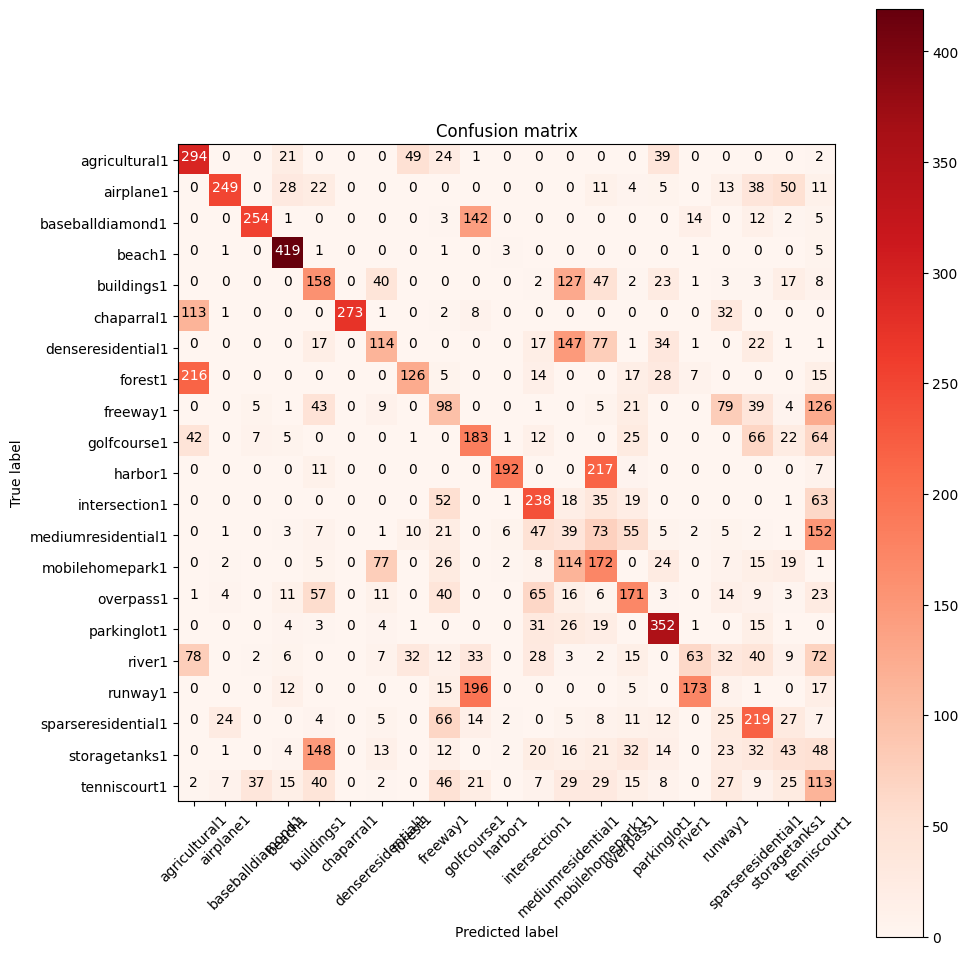

In [29]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

In [30]:
# model = tf.keras.applications.ResNet101(
#     include_top=False,
#     input_tensor=None,
#     input_shape=(64,64, 3),
#     classes=10,
# )
# model.summary()

Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.75       0.25      ]
 [0.         0.33333333 0.66666667]]


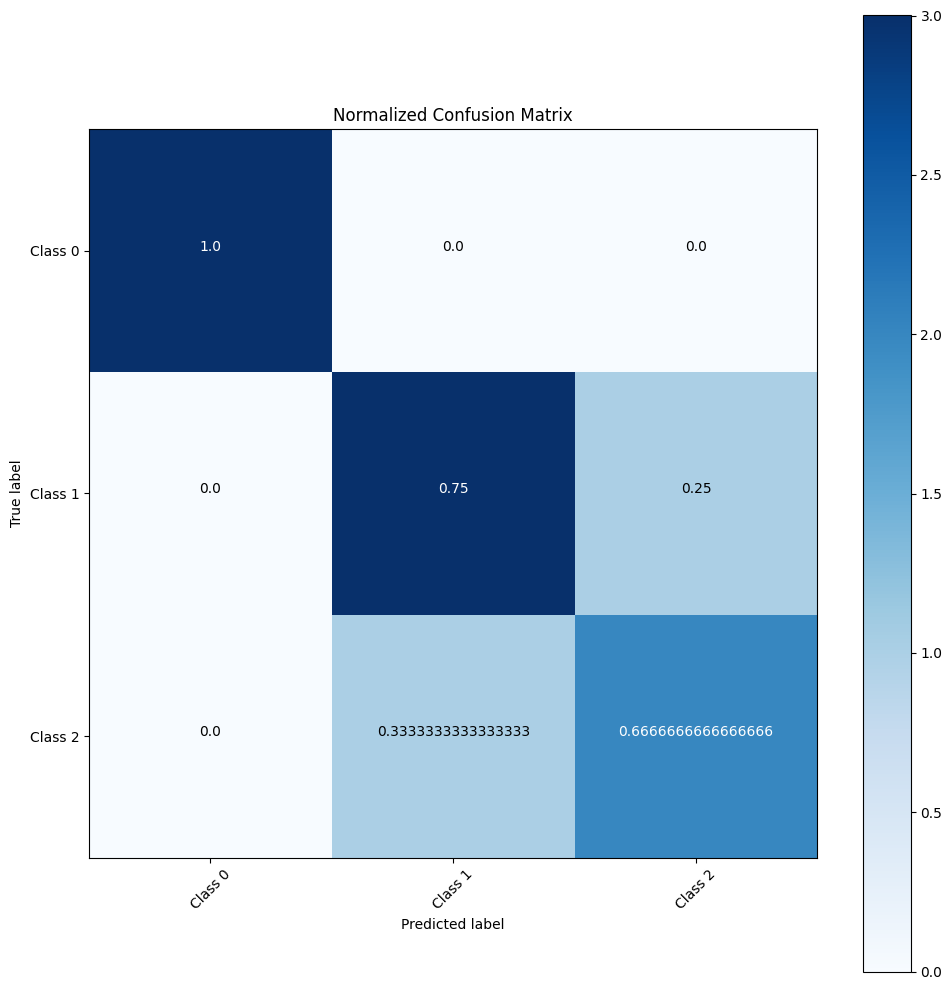

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Assuming y_true and y_pred are your true and predicted labels
y_true = np.array([1, 0, 1, 2, 2, 0, 1, 2, 0, 1])
y_pred = np.array([1, 0, 1, 2, 1, 0, 2, 2, 0, 1])

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define your class labels
classes = ["Class 0", "Class 1", "Class 2"]

# Plot the confusion matrix
plot_confusion_matrix(cm, classes, normalize=True, title='Normalized Confusion Matrix')
plt.show()


# Thank you